In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
from smyleutils import averaging_utils as avg
from smyleutils import histoplot_utils as histo
from smyleutils import bootstrap_utils as boot
import sys

In [12]:
plotpath="/project/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

In [2]:
basepath="/project/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"

high_nov=xr.open_dataset(basepath+'Uzm_BSMYLE-CW3E-L83_day_init11.nc').Uzm
low_nov=xr.open_dataset(basepath+'Uzm_BSMYLE-CW3E_day_init11.nc').Uzm ; low_nov['lat'] = high_nov.lat
era5_nov=xr.open_dataset(basepath+'Uzm_ERA5_day_init11.nc').Uzm ; era5_nov['lat'] = high_nov.lat

### Grab out the January's

In [3]:
high_jan = high_nov.sel(time=slice("1971-01-01","1971-01-31")).mean('time')
low_jan = low_nov.sel(time=slice("1971-01-01","1971-01-31")).mean('time')
era5_jan = era5_nov.sel(time=slice("1971-01-01","1971-01-31")).mean('time')

In [4]:
era5_jan_50 = era5_jan.sel(level=50)
high_jan_50 = high_jan.interp(ilev=50)
low_jan_50 = low_jan.interp(ilev=50)

era5_jan_10 = era5_jan.sel(level=10)
high_jan_10 = high_jan.interp(ilev=10)
low_jan_10 = low_jan.interp(ilev=10)

In [5]:
era5_jan_50_tr = avg.cosweightlat(era5_jan_50, -5,5)
high_jan_50_tr = avg.cosweightlat(high_jan_50,-5,5)
low_jan_50_tr = avg.cosweightlat(low_jan_50,-5,5)

era5_jan_10_60 = era5_jan_10.interp(lat=60)
high_jan_10_60 = high_jan_10.interp(lat=60)
low_jan_10_60 = low_jan_10.interp(lat=60)

DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


In [41]:
era5_cor = xr.corr(era5_jan_50_tr, era5_jan_10_60)
high_cor = xr.corr(high_jan_50_tr.mean('M'), high_jan_10_60.mean('M'))
low_cor = xr.corr(low_jan_50_tr.mean('M'), low_jan_10_60.mean('M'))

In [ ]:
boot_tr_high=[] ; boot_pv_high=[]
boot_tr_low=[] ; boot_pv_low=[]

for iyear in np.arange(0,high_jan_50_tr.init_year.size,1):
    boot_tr = boot.bootgen(high_jan_50_tr.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_pv = boot.bootgen(high_jan_10_60.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_tr_high.append(boot_tr)
    boot_pv_high.append(boot_pv)
    
    boot_tr = boot.bootgen(low_jan_50_tr.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_pv = boot.bootgen(low_jan_10_60.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_tr_low.append(boot_tr)
    boot_pv_low.append(boot_pv)
    
boot_tr_high = xr.concat(boot_tr_high, dim=high_jan_50_tr.init_year)
boot_pv_high = xr.concat(boot_pv_high, dim=high_jan_50_tr.init_year)
boot_tr_low = xr.concat(boot_tr_low, dim=low_jan_50_tr.init_year)
boot_pv_low = xr.concat(boot_pv_low, dim=low_jan_50_tr.init_year)

In [8]:
boot_cor_high = xr.corr(boot_tr_high, boot_pv_high, dim='init_year')
boot_cor_low = xr.corr(boot_tr_low, boot_pv_low, dim='init_year')

In [21]:
min95_boot_cor_high = boot_cor_high.quantile(0.025) ; max95_boot_cor_high = boot_cor_high.quantile(0.975)
min95_boot_cor_low = boot_cor_low.quantile(0.025) ; max95_boot_cor_low = boot_cor_low.quantile(0.975)

In [35]:
p_l83 = ((boot_cor_high.where(boot_cor_high > era5_cor, drop=True).sum()/ boot_cor_high.size)*100.).values
p_l32 = ((boot_cor_low.where(boot_cor_low > era5_cor, drop=True).sum()/ boot_cor_low.size)*100.).values

In [36]:
print(p_l32)

0.0


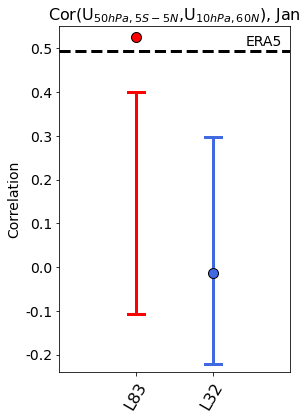

In [42]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.05,0.7,0.2,0.3])
ax.set_xlim([0,3])
ax.set_xticks([1,2])
ax.set_xticklabels(['L83','L32'], rotation=60, ha="right", fontsize=16, rotation_mode="anchor")
ax.set_yticks([-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5])
ax.set_yticklabels(['-0.2','-0.1','0.0','0.1','0.2','0.3','0.4','0.5'], fontsize=14)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_ylim(-0.24,0.55)
ax.set_title('Cor(U$_{50hPa,5S-5N}$,U$_{10hPa, 60N}$), Jan', fontsize=16)

#ax = histo.oplotbar(ax, 1, era5_cor, color='black')

ax.plot([0,3],[era5_cor, era5_cor], color='black', linewidth=3, linestyle='dashed')
ax.plot([1,1],[min95_boot_cor_high, max95_boot_cor_high], color='red', linewidth=3)
ax.plot([0.9,1.1],[min95_boot_cor_high, min95_boot_cor_high], color='red', linewidth=3)
ax.plot([0.9,1.1],[max95_boot_cor_high, max95_boot_cor_high], color='red', linewidth=3)
ax.plot(1,high_cor,"o", markerfacecolor='red', markeredgecolor='black', markersize=10)


ax.plot([2,2],[min95_boot_cor_low, max95_boot_cor_low], color='royalblue', linewidth=3)
ax.plot([1.9,2.1],[min95_boot_cor_low, min95_boot_cor_low], color='royalblue', linewidth=3)
ax.plot([1.9,2.1],[max95_boot_cor_low, max95_boot_cor_low], color='royalblue', linewidth=3)
ax.plot(2,low_cor,"o", markerfacecolor='royalblue', markeredgecolor='black', markersize=10)

ax.text(2.9,0.515,'ERA5', fontsize=14, color='black', ha='right', va='center')

fig.savefig(plotpath+'fig4_holtontan.png', bbox_inches='tight', facecolor='white')

In [14]:
print(era5_cor)

<xarray.DataArray 'Uzm' ()>
array(0.49290838)
Coordinates:
    zlon     float64 0.0
    lat      int64 60
